In [546]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import data_utils
importlib.reload(data_utils)
import pipeline
importlib.reload(pipeline)
import pipelines
importlib.reload(pipelines)
import draw_utils
importlib.reload(draw_utils)
import linreg_utils
importlib.reload(linreg_utils)
from pipeline import Pipeline

Ради интереса я решил написать свою мини-библиотеку, с помощью которой можно конфигурировать обработку данных и делать красивые визуализации

### Загрузка и преобразование данных

In [547]:
pipe = Pipeline('generate_data')
pipe.generate('dataset', pd.read_csv, filepath_or_buffer="_file")
pipe.transform('dataset', 'features', lambda df, target: df.drop(target, axis=1), target="_drop")
pipe.transform('dataset', 'labels', lambda df, target: df[target], target="_target")
pipe.transform('features', 'features_names', lambda f: f.columns)
pipe.transform('features', 'X', data_utils.to_mat)
pipe.transform('labels', 'Y', data_utils.to_mat)
cars_cat_num = pipe.process_copy("cat_num", _file='data/cars_cat_num.csv',
    _target='Transmission', _drop='Transmission')
cars_onehot = pipe.process_copy("onehot", _file='data/cars_onehot.csv',
    _target='Transmission_Manual', _drop=['Transmission_Manual', 'Transmission_Automatic'])

### Визуализация

In [548]:
def draw_train_results(title, pipes):
    def draw_metrics(ax, p):
        draw_utils.draw_metric(["loss"])(ax, p),
        draw_utils.draw_stats(ax, p, ['accuracy', 'recall', 'precision', 'f1_measure'])

    def draw_stats(ax, p):
        draw_utils.draw_compare_stats('W', labels=list(p.val('features_names'))+['bias'])(ax, p)
        
    draw_utils.draw_plots(pipes, [draw_metrics, draw_stats], title=title, max_cols=1)

### Логистическая регрессия

In [549]:
reg = Pipeline('reg')
reg.subpipeline(pipelines.transform_data(['X']))
reg.subpipeline(pipelines.prepare_data())
reg.subpipeline(pipelines.split_test_train())
reg.subpipeline(pipelines.load_train())
reg.subpipeline(pipelines.train_model([pipelines.gradient_descent(), pipelines.regularization()], pred=pipelines.classify_binary()))
args = {'_epochs':30, '_batch':3000, '_loss_BCE':True, '_act_sigmoid':True, '_threshold':0.5, '_conf_mat':True}

In [550]:
def print_stats(title, p):
    metrics = ('accuracy', 'recall', 'precision', 'f1_measure')

    print(title, 'metrics:')
    for m in metrics:
        print('\t', m, p.val(m))



def train_and_test(title, data, model, **args):
    model = model.apply_copy(model.name, data, **args)
    draw_train_results(title, [model])

    train = Pipeline.compose_apply("train", model, [pipelines.load_train(), pipelines.classify_binary(), pipelines.metrics()], **args)
    print_stats('Train', train)

    test = Pipeline.compose_apply("test", model, [pipelines.load_test(), pipelines.classify_binary(), pipelines.metrics()], **args)
    print_stats('Test', test)

    labels=list(model.val('features_names'))+['bias']
    a = np.ravel(np.abs(model.val('W')))
    ind = np.ravel(np.argpartition(a, -3))[-3:]

    print('Самые значимые веса:')
    for i in ind[np.argsort(-a[ind])]:
        print('\t', labels[i], model.val('W')[0, i])

## Обучение и тестирование линейной регрессии

### На категориальных данных, преобразованных в числовые

#### Без предварительной обработки

c:\Users\BinaryCat17\Documents\Projects\innopolis_course\linreg_utils.py:50: RuntimeWarning: overflow encountered in exp
  def lasso_reg_loss(B, l):


Train metrics:
	 accuracy 0.7135943864177118
	 recall 0.8415568951402843
	 precision 0.694551931699527
	 f1_measure 0.7610202570832492
Test metrics:
	 accuracy 0.7172580645161291
	 recall 0.8394074074074074
	 precision 0.700544015825915
	 f1_measure 0.7637147863593476
Самые значимые веса:
	 Price(euro) -140.2812491673197
	 km_year -59.10141484041079
	 Distance 15.413356703548331


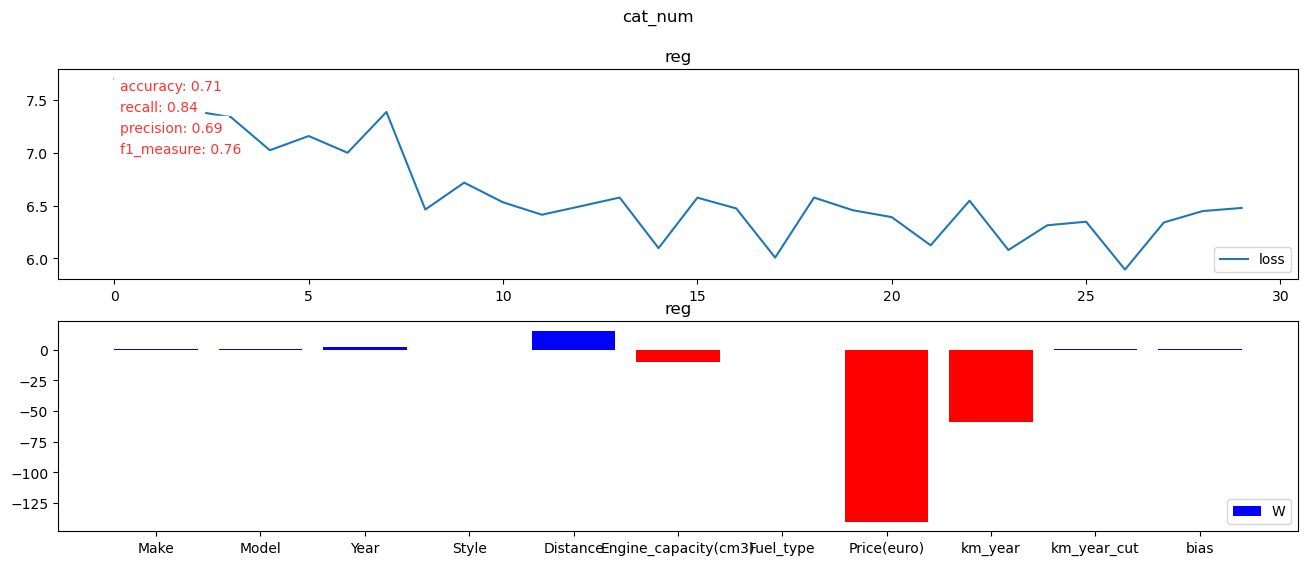

In [551]:
train_and_test('cat_num', cars_cat_num, reg, **args, _lr=0.0005)

#### На нормализованном наборе данных

Train metrics:
	 accuracy 0.7812638625640198
	 recall 0.8817404239494235
	 precision 0.7556249601631716
	 f1_measure 0.8138257705773323
Test metrics:
	 accuracy 0.7830645161290323
	 recall 0.8907038907038907
	 precision 0.7542756539235412
	 f1_measure 0.8168323573471333
Самые значимые веса:
	 Price(euro) -4.43001181528176
	 Engine_capacity(cm3) -3.1990983233588333
	 bias 2.402490323439491


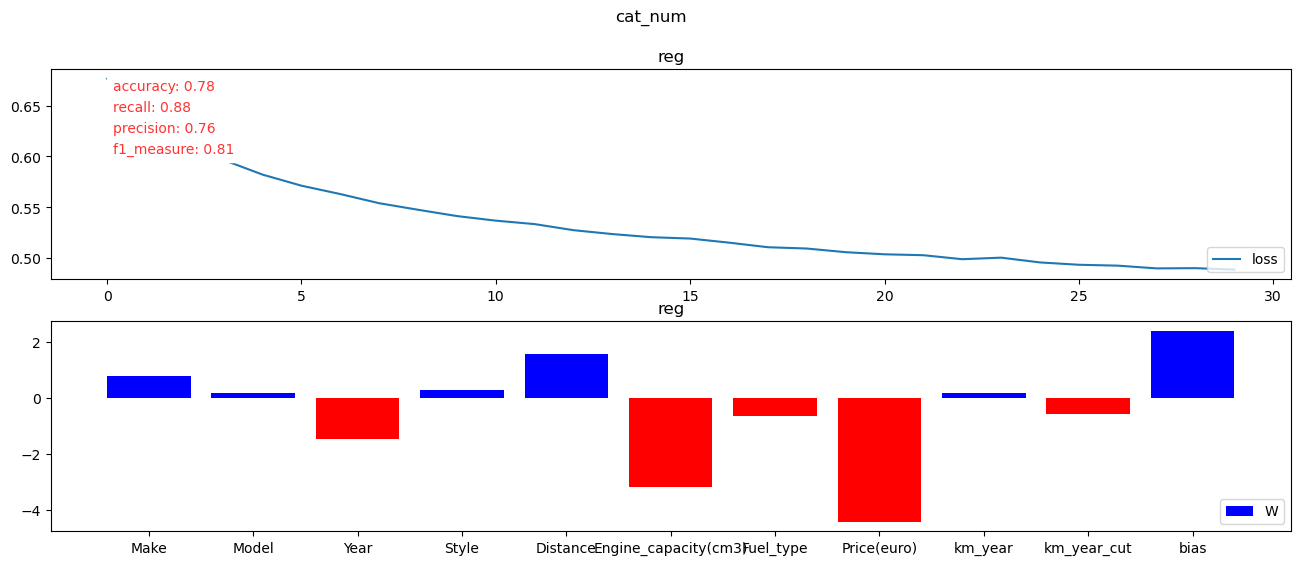

In [552]:
train_and_test('cat_num', cars_cat_num, reg, **args, _lr=1, _minmax=True)

#### На стандартизированном наборе данных

Train metrics:
	 accuracy 0.8100979957252894
	 recall 0.8798870224468559
	 precision 0.792847096644565
	 f1_measure 0.8341025189360578
Test metrics:
	 accuracy 0.8088709677419355
	 recall 0.8773079213817748
	 precision 0.7921484269965045
	 f1_measure 0.8325561678677406
Самые значимые веса:
	 Price(euro) -1.2118410936500996
	 Engine_capacity(cm3) -0.9623984242669218
	 Year -0.7731186235075136


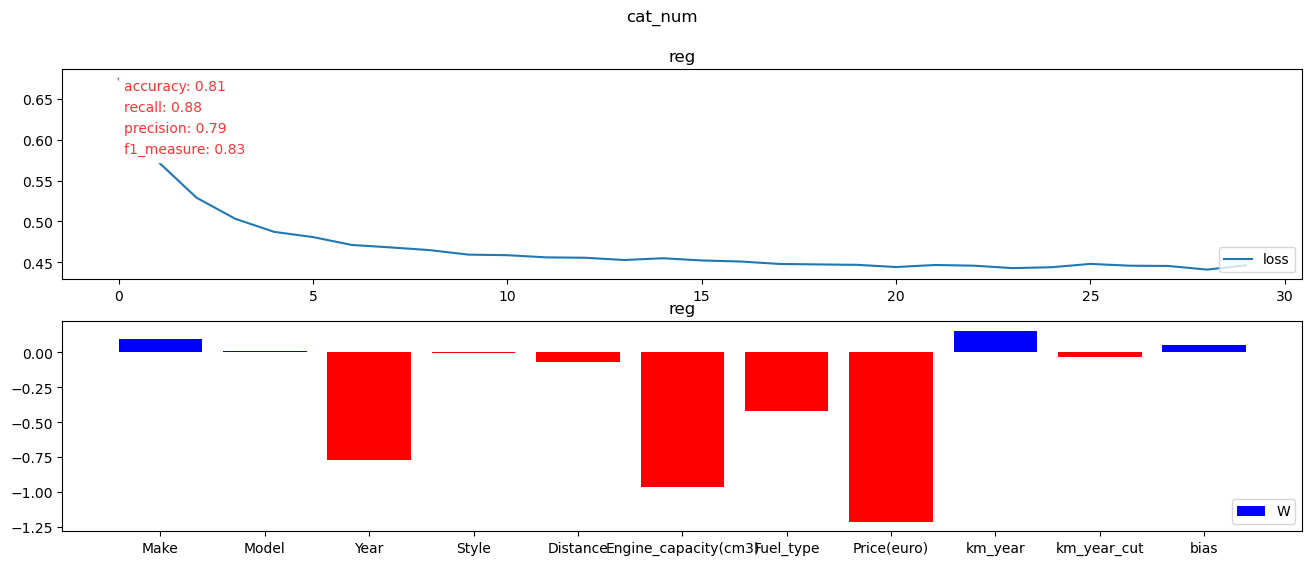

In [553]:
train_and_test('cat_num', cars_cat_num, reg, **args, _lr=0.1, _std=True)

### На one-hot encoding

#### Без предварительной обработки

Train metrics:
	 accuracy 0.7153284671532847
	 recall 0.822043371339146
	 precision 0.7025219717233473
	 f1_measure 0.7575976099721851
Test metrics:
	 accuracy 0.7175806451612903
	 recall 0.8205128205128205
	 precision 0.7091186958736627
	 f1_measure 0.7607596666211232
Самые значимые веса:
	 Price(euro) -141.7619891104703
	 km_year -62.17132211248455
	 Distance 14.983650977737597


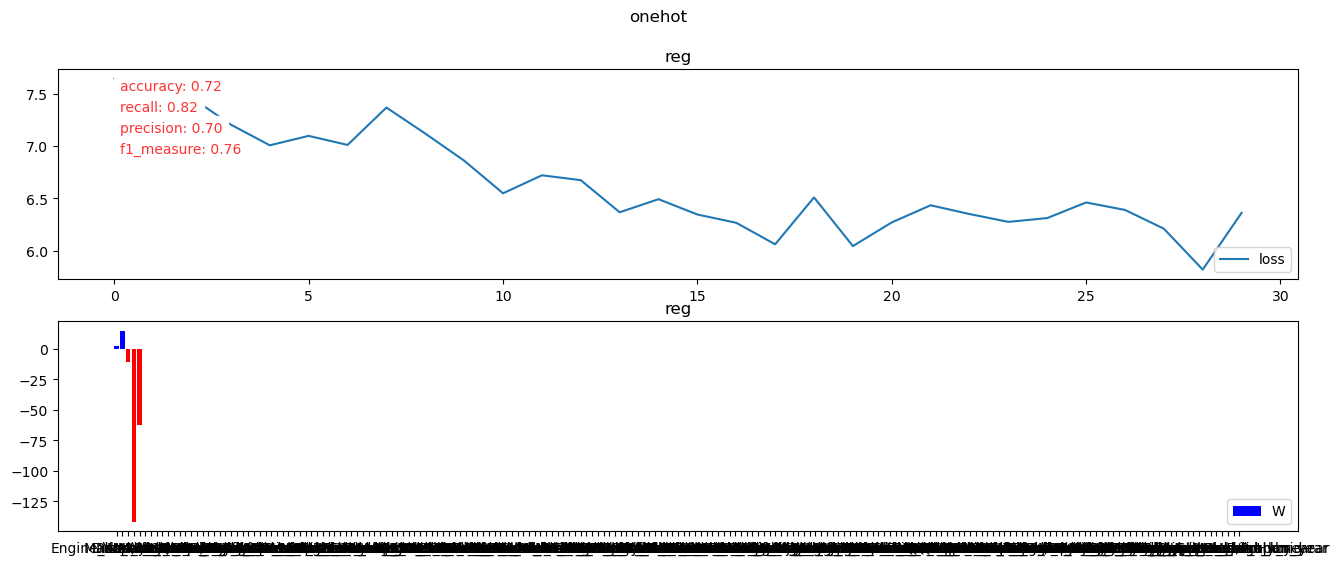

In [554]:
train_and_test('onehot', cars_onehot, reg, **args, _lr=0.0005)

#### На нормализованном наборе данных

Train metrics:
	 accuracy 0.8326410452877364
	 recall 0.8771813073055309
	 precision 0.8265746934225195
	 f1_measure 0.8511264169895251
Test metrics:
	 accuracy 0.8398387096774194
	 recall 0.8786496350364964
	 precision 0.8294573643410853
	 f1_measure 0.8533451484271156
Самые значимые веса:
	 Price(euro) -2.896827354631254
	 Year -2.2054231450511654
	 Engine_capacity(cm3) -1.8326857472519318


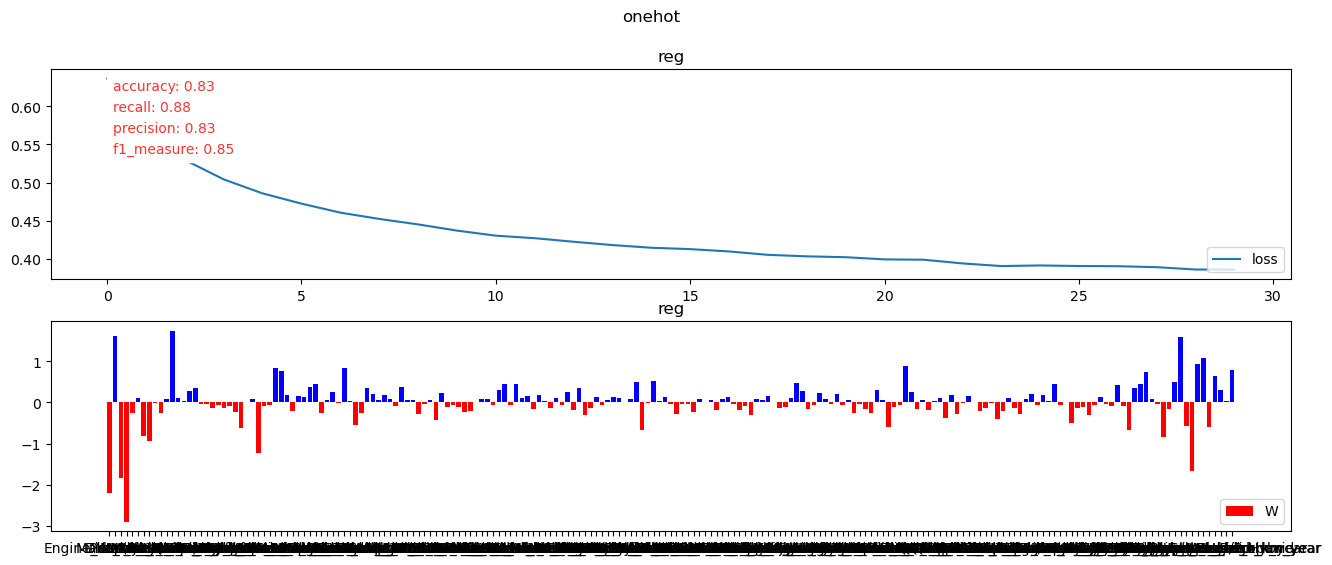

In [555]:
train_and_test('onehot', cars_onehot, reg, **args, _lr=1, _minmax=True)

#### На стандартизированном наборе данных

Самого лучшего результата добилась модель с использованием onehot encoded набора данных и стандартизации

Train metrics:
	 accuracy 0.8541759083760132
	 recall 0.8996575852315022
	 precision 0.841995262644559
	 f1_measure 0.8698718871455304
Test metrics:
	 accuracy 0.8554838709677419
	 recall 0.9008288928359977
	 precision 0.8443396226415094
	 f1_measure 0.8716700085935262
Самые значимые веса:
	 Price(euro) -1.2130140776635758
	 Year -0.8460139294958436
	 Fuel_type_Hybrid -0.8204970737115297


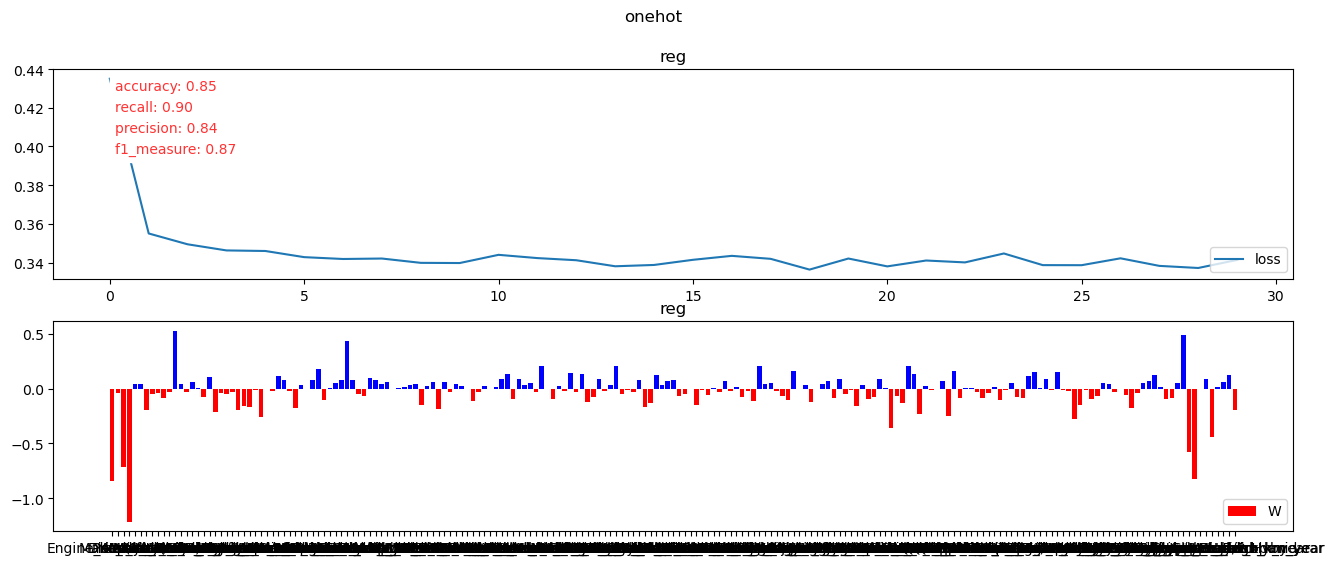

In [556]:
train_and_test('onehot', cars_onehot, reg, **args, _lr=1, _std=True)